In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

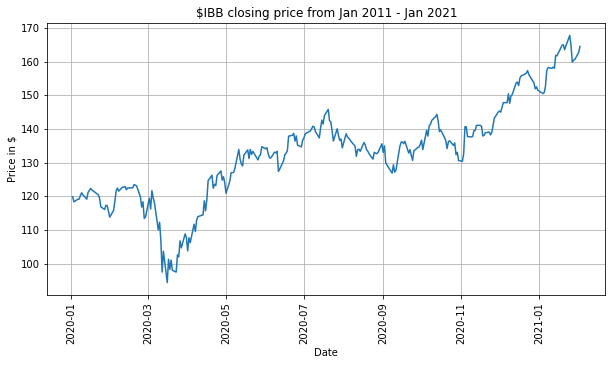

In [36]:
def parser(x):
    return datetime.strptime(x, "%Y-%m-%d")

#Explain tables properties


data = pd.read_csv('IBBmonth.csv', usecols=[0,4], parse_dates=[0], header=0, date_parser=parser)
plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(data['Date'], data['Close'])
plt.title('$IBB closing price from Jan 2011 - Jan 2021')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

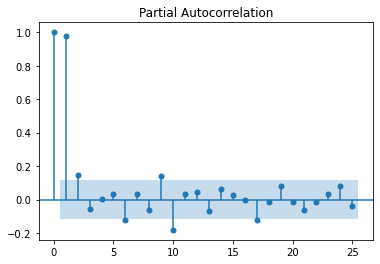

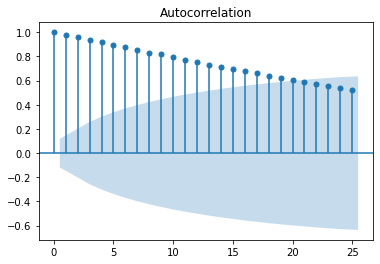

In [37]:
#Autocorrelation and Partial autocorrelation

plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [38]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.42928242242252
p-value: 0.9050936653982494


In [39]:
# Take the log difference to make data stationary
#
#data['Close'] = np.log(data['Close'])
#data['Close'] = data['Close'].diff()
#data = data.drop(data.index[0])
#data.head()

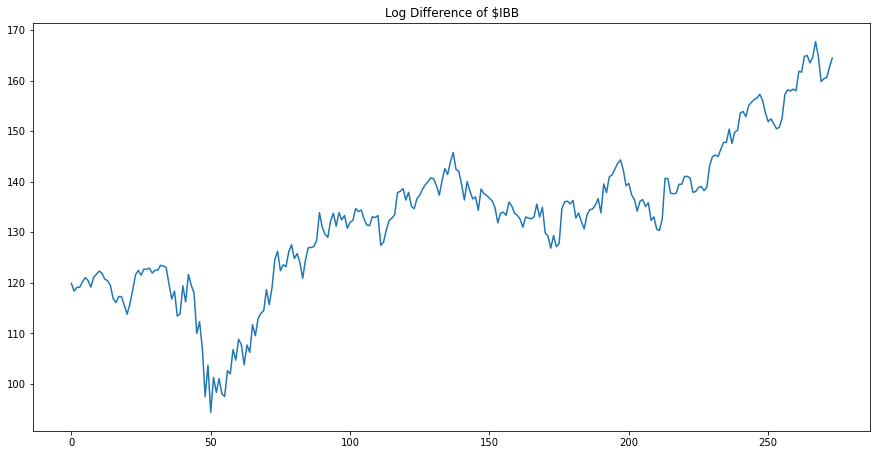

In [40]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Close'])
plt.title("Log Difference of $IBB")
plt.show()

In [41]:
# Augmented Dickey-Fuller test for log

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.42928242242252
p-value: 0.9050936653982494


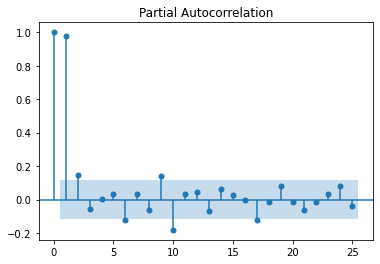

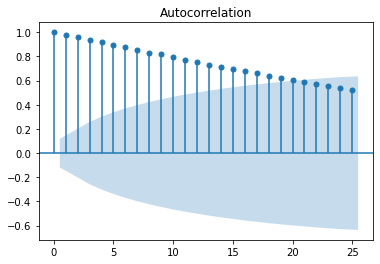

In [42]:
#Autocorrelation and Partial autocorrelation after log

plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [43]:
#Split test and train dataset
#train_data, test_data = train_test_split(data['Close'], test_size=0.33, shuffle = False, stratify = None)
#
#test_data = test_data.reset_index()
#print(train_data.head())
#print(test_data.head())
#

train_data, test_data = data[0:int(len(data)*0.7)], data[int(len(data)*0.7):]

train_data = train_data['Close'].values
test_data = test_data['Close'].values

In [44]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.6f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p = [0,1,2,3,4,5,6,7,8,9]
d = range(0,3)
q = range(0,3)

evaluate_models(train_data, p, d, q)

ARIMA(0, 0, 0) MSE=148.737625
ARIMA(0, 0, 1) MSE=46.910313
ARIMA(0, 0, 2) MSE=24.819082
ARIMA(0, 1, 0) MSE=4.453309
ARIMA(0, 1, 1) MSE=4.365863
ARIMA(0, 1, 2) MSE=4.358331
ARIMA(0, 2, 0) MSE=10.279114
ARIMA(0, 2, 1) MSE=4.609126
ARIMA(0, 2, 2) MSE=4.575058
ARIMA(1, 0, 0) MSE=4.406360
ARIMA(1, 0, 1) MSE=4.299868
ARIMA(1, 0, 2) MSE=4.293436
ARIMA(1, 1, 0) MSE=4.402762
ARIMA(1, 1, 1) MSE=4.436506
ARIMA(1, 1, 2) MSE=4.424194
ARIMA(1, 2, 0) MSE=6.939911
ARIMA(1, 2, 1) MSE=4.616098
ARIMA(1, 2, 2) MSE=4.639309
ARIMA(2, 0, 0) MSE=4.331523
ARIMA(2, 0, 1) MSE=4.368077
ARIMA(2, 0, 2) MSE=4.353225
ARIMA(2, 1, 0) MSE=4.453541
ARIMA(2, 1, 1) MSE=4.461336
ARIMA(2, 1, 2) MSE=4.617864
ARIMA(2, 2, 0) MSE=5.796152
ARIMA(2, 2, 1) MSE=4.646389
ARIMA(2, 2, 2) MSE=4.992719
ARIMA(3, 0, 0) MSE=4.395542
ARIMA(3, 0, 1) MSE=4.433163
ARIMA(3, 0, 2) MSE=4.603156
ARIMA(3, 1, 0) MSE=4.441830
ARIMA(3, 1, 1) MSE=4.597322
ARIMA(3, 1, 2) MSE=4.749701
ARIMA(3, 2, 0) MSE=5.719650
ARIMA(3, 2, 1) MSE=4.626279
ARIMA(3, 2, 2) 

In [52]:
ARIMA_model = ARIMA(train_data, order=(1,1,1)).fit()

print(ARIMA_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  190
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -445.619
Method:                       css-mle   S.D. of innovations              2.525
Date:                Thu, 04 Feb 2021   AIC                            899.238
Time:                        17:50:51   BIC                            912.227
Sample:                             1   HQIC                           904.500
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0782      0.150      0.520      0.603      -0.217       0.373
ar.L1.D.y     -0.4681      0.164     -2.849      0.004      -0.790      -0.146
ma.L1.D.y      0.2044      0.175      1.166      0.2

In [46]:
# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(ARIMA_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [2.00574453e-02 8.21336863e-01 1.05572459e+00 1.58883945e+00
 1.58947214e+00 6.61975982e+00 7.88364685e+00 1.17398935e+01
 2.38126687e+01 2.39564729e+01]
p-value: [0.88737676 0.66320679 0.78777163 0.81079662 0.90251953 0.35744616
 0.34296563 0.16319194 0.00460751 0.00771677]


In [60]:
# 2,1,0 ?

history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)




In [59]:
MSE = mean_squared_error(test_data, model_predictions)
print('Mean Squared Error: {}'.format(MSE))

MAE = mean_absolute_error(test_data, model_predictions)
print('Mean Absolute Error: {}'.format(MAE))

Mean Squared Error: 4.74283770216386
Mean Absolute Error: 1.6173439064137807


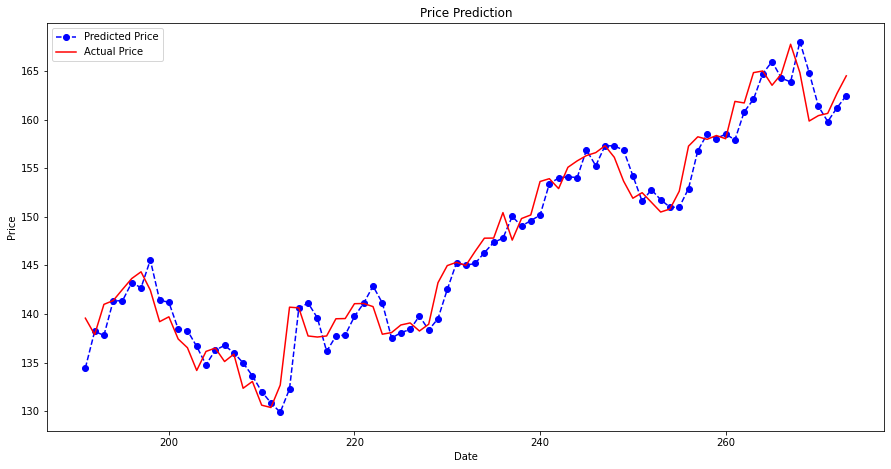

In [55]:
test_set_range = data[int(len(data)*0.7):].index
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()